In [ ]:
#importamos las librerias que vamos a usar
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sql alchemi tiene muchos imports pero lo ponemos aqui para avitar usar el alias sa.Table sa.Integer,etc
from sqlalchemy import create_engine, MetaData, Table, Column,Integer, String, DECIMAL, text, insert

In [ ]:
#Declaramos variables iniciales
# La Url De La Api Worldbank
url = "https://api.worldbank.org/v2/country/"
# El Formato De Devolucion
format = "json"
#Los Elementos Por Pagina Usualmente Se Usa Para No Cargar Todo De Golpe
per_page = 50
#Los Paises Que Vamos A Analizar En Este Caso Agregue Uno Mas Para Ver Diferencias Mas Notorias En Las Graficas
countries=["ESP", "VEN", "USA", "ITA", "RWA", "ETH"]
#Construimos La Url Agregando ";" Entre Paises Como Lo Especifica La Documentacion De Worldbank
url_with_countrys = url + ";".join(countries)

#Esta Funcion Recibe La Url Y Un Rango De Fechas, Desvuelve Un Json Con Todas Las Paginas, Es Decir Hace Tantas Solicitudes Como Paginas Totales
#Y Las Junta Todas En Un Resultado
def api_request_all_pages(url, date_start = None, date_end = None):
    #Inicializamos La Lista Result Y La Variable Page Que Va A Ir Aumentando Por Solicitud
    result = []
    page = 1
    #Iniciamos El Bucle Siempre Se Va A Ejecutar Al Menos 1 Vez Cuando "Page < Total_Pages" Se Pausara
    while True:
        #Aca Establecemos Los Parametros Para Luego Construir La Url
        params = {
            "source": 2, # Source 2 Se Usa Cuando Se Especifican Mas De Un Indicador
            "format": format,
            "per_page": per_page,
            "page": page
           
        }
        #Solo Añadimos El Parametro Date Si Se Pasan En Los Parametros
        if date_start != None and date_end != None:
            params["date"] = f"{str(date_start)}:{str(date_end)}"
        #Recibirmos Y Convertimos A Json
        response = requests.get(url, params = params, timeout = 30)
        #Hacemos esto para detener la ejecucion en caso de que falle la solicitud
        response.raise_for_status()
        payload = response.json()
        #Vemos Cuantas Veces Tenemos Que Repetir El Ciclo Por El Total De Paginas
        total_pages = payload[0]["pages"]
        #Vamos Añadiendo Al Resultado Final
        result += payload[1]
        #Si Aun No Estamos En La Ultima Pagina Sumamos Uno A La Variable Page Y Continuamos El Ciclo De Otra Manera Lo Pausamos Con "Break"
        if page < total_pages:
            page += 1
        else:
            break
    #Devolvemos Todo Junto
    return result



In [27]:
#Definimos Los 4 Inicadores Un Una Lista:Población Total,Pib Per Cápita (Usd Actuales) ,Tasa De Desempleo,Esperanza De Vida Al Nacer (Años) 
#En Ese Orden  
indicators = ["SP.POP.TOTL", "NY.GDP.PCAP.CD", "SL.UEM.TOTL.ZS", "SP.DYN.LE00.IN"]
#Fechas De Inicio Y Final Como Especifica El Ejercicio
date_start = 2010
date_end = 2024
#Construimos La Url Final Compliendo La Estructura Que Especifica La Documentacion De Worldbank
final_url = url_with_countrys+"/indicator/" + ";".join(indicators)
#Lo pasamos a la funcion que explicamos antes y lo guardamos en una variable
countries_with_indicator = api_request_all_pages(final_url,date_start, date_end) 
countries_with_indicator


[{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
  'country': {'id': 'ES', 'value': 'Spain'},
  'countryiso3code': 'ESP',
  'date': '2024',
  'value': 48848840,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
  'country': {'id': 'ES', 'value': 'Spain'},
  'countryiso3code': 'ESP',
  'date': '2023',
  'value': 48352528,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
  'country': {'id': 'ES', 'value': 'Spain'},
  'countryiso3code': 'ESP',
  'date': '2022',
  'value': 47786102,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
  'country': {'id': 'ES', 'value': 'Spain'},
  'countryiso3code': 'ESP',
  'date': '2021',
  'value': 47443821,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
  'count

In [ ]:
#Definimos una funcion que ajusta algunas columnas para que muestre lo que queremos esta misma recibe una fila o tupla.
def clean_indicator_df(df_row):
    #hay columnas que dentro tienen otro diccionario lo modificamos para que quede como queremos
    df_row["indicator"] = df_row["indicator"]["id"]
    df_row["country"] = df_row["country"]["value"]
    #Nos aseguramos que el año sea entero
    df_row["date"] = int(df_row["date"])
    #Que el valor del indicador sea float
    df_row["value"] = round(float(df_row["value"]), 2)
    #Y devolvemos la fila
    return df_row

#antes de usar la funcion convertimos lo que obtuvimos antes en un dataframe de pandas 
df_countries_with_indicator = pd.DataFrame(countries_with_indicator)
#le decimos que solo muestre las columnas que nos interezan
df_countries_with_indicator = df_countries_with_indicator[["indicator", "country", "countryiso3code", "date", "value"]]
#Ahora si aplicamos la funcion a cada tupla o fila con "apply" pasandole la funcion y axis=1 para que pase las filas y no las columnas
df_countries_with_indicator = df_countries_with_indicator.apply(clean_indicator_df, axis = 1)
#Le cambiamos el nombre a las columnas traduciendolas al español
df_countries_with_indicator.columns=["Indicador", "Pais", "Pais(Iso3)", "Año", "Valor"]

#filtramos nuestro data frame por indicador aprochando de eliminar aquellas filas que tengan valores nulos
#ademas renombramos la columna valor para que se ajuste al indicador, hacemos lo mismo con los cuatro indicadores
df_population = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SP.POP.TOTL"][["Pais", "Pais(Iso3)", "Año", "Valor"]].dropna(axis = 0)
df_population = df_population.rename(columns = {"Valor": "Poblacion Total"})

df_PIB = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "NY.GDP.PCAP.CD"][["Pais", "Pais(Iso3)", "Año", "Valor"]].dropna(axis = 0)
df_PIB = df_PIB.rename(columns = {"Valor": "PIB Per Capita"})

df_unemployment = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SL.UEM.TOTL.ZS"][["Pais", "Pais(Iso3)", "Año", "Valor"]].dropna(axis = 0)
df_unemployment = df_unemployment.rename(columns = {"Valor": "Tasa Desempleo"})

df_life_hope = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SP.DYN.LE00.IN"][["Pais", "Pais(Iso3)", "Año", "Valor"]].dropna(axis = 0)
df_life_hope = df_life_hope.rename(columns = {"Valor": "Esperanza De Vida"})
df_population

,Pais,Pais(Iso3),Año,Poblacion Total
0,Spain,ESP,2024,48848840.0
1,Spain,ESP,2023,48352528.0
2,Spain,ESP,2022,47786102.0
3,Spain,ESP,2021,47443821.0
4,Spain,ESP,2020,47359424.0
...,...,...,...,...
85,"Venezuela, RB",VEN,2014,30254079.0
86,"Venezuela, RB",VEN,2013,29912198.0
87,"Venezuela, RB",VEN,2012,29553826.0
88,"Venezuela, RB",VEN,2011,29185212.0


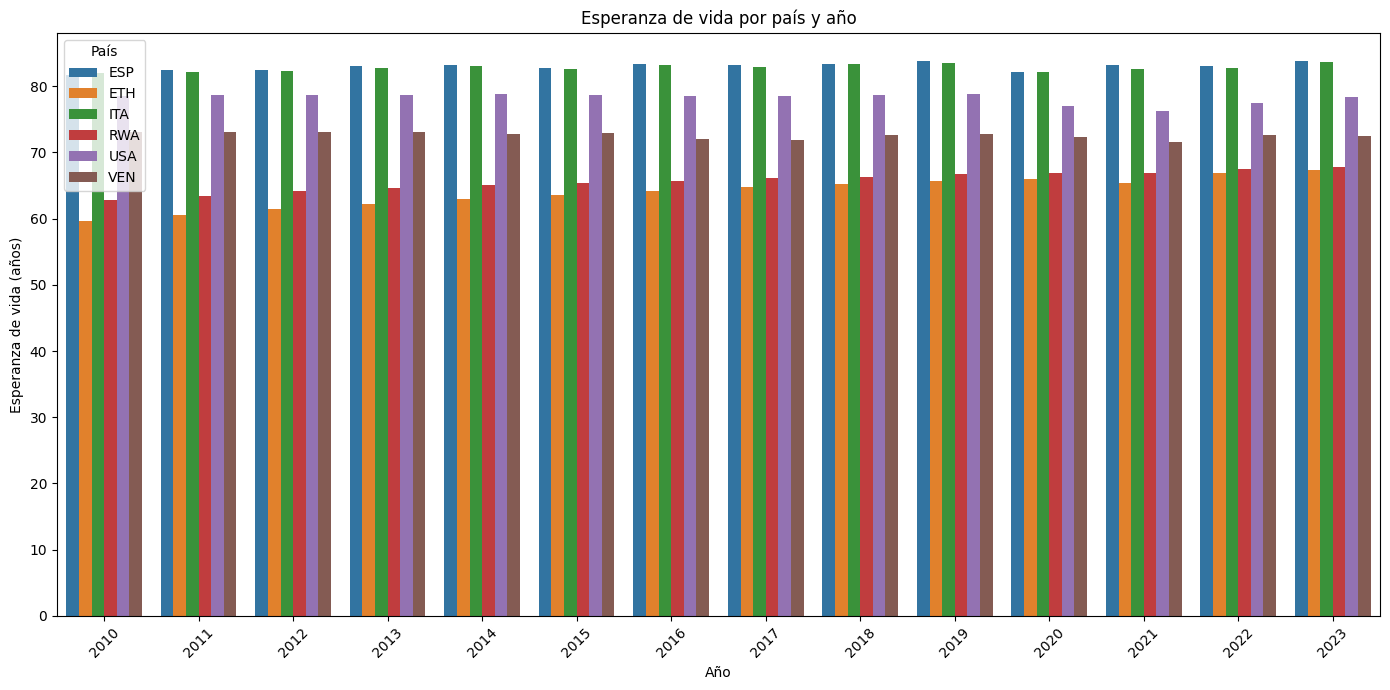

In [ ]:
#creamos un grafico de barras "Esperanza de vida por pais y año" en este caso solo necesitamos 1 de los 4 datafreames que creamos
plt.figure(figsize = (14, 7))
sns.barplot(
    data = df_life_hope, #le pasamos el dataframe
    x = "Año", #Columna Eje X
    y = "Esperanza De Vida",#Columna Eje Y
    hue = "Pais(Iso3)", #Separamos por pais para que muestre una barra diferente por pais adeas de añadir la leyenda
    palette = "tab10" #la paleta de colores
)
#configuramos un poco los titulos y las etiquetas
plt.title("Esperanza de vida por pais y año")
plt.xlabel("Año")
plt.ylabel("Esperanza de vida (años)")
plt.legend(title = "Pais")
plt.xticks(rotation = 45)
#intentamos evitar que se solapen las etiquetas con tight_layout
plt.tight_layout()
plt.show()

Descripcion del grafico:el grafico es uno de barras verticales representando la esperanza de vida de 6 paises a lo largo de los años 2010-2024(la api de https://api.worldbank.org/ por alguna razon no retorna el año 2024 para este indicador para el resto si).

Observaciones:
    1- A lo largo de los años que estamos evaluando no se observan cambios significativos entre mismos paises, esto de puede entender como relativa estabilidad(enfasis en relativa) mientras que en datos del siglo pasado quizas si se pudieran observar cambios mas evidentes entre los años.
    2- Paises desarrollados como España, Italia y estados unidos presentan una mejor esperanza de vida, paises como venezuela tiene una esperanza de vida relativamente alta pero con matizes, paises como Etiopía y Ruanda no tienen esperanzas de vida tan altas.

Nota:la calidad de los indicadores depende de la calidad (y honestidad) de las instituciones que los reportan y aunque el Banco Mundial, La ONU,La OMS,El FMI usan sus propios metodos de verificacion los gobiernos son la fuente primaria de muchos indicadores explicando porque paisen con un decenso economico y estructural a nivel de salud como venezuela se mantiene igual en numeros al pasar de los años.




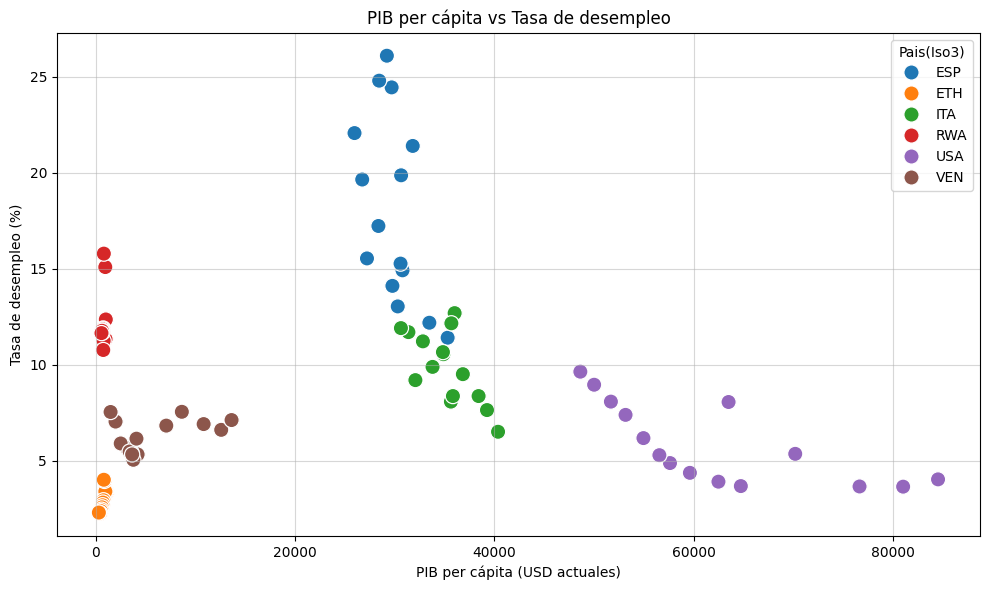

In [ ]:
#Creamos un grafico scatter "PIB per capita vs Tasa de desempleo" en este caso si necesitamos relacionar dos dataframes
#Vamos a unirlos con merge "df_PIB" y "df_unemployment", es parecido a un join de SQL
df_scatter = df_PIB.merge(df_unemployment, 
                          on = ["Pais(Iso3)", "Año"], #Solo se unirán filas donde coincidan a la vez
                          how = "inner") # Solo conserva las filas que cummplen con lo anterior, otra forma posible seria excluyente
plt.figure(figsize = (10, 6))
sns.scatterplot(
    data = df_scatter,#Le pasamos el dataframe
    x = "PIB Per Capita",#Columna Eje X
    y = "Tasa Desempleo",#Columna Eje Y
    hue = "Pais(Iso3)",#Separamos por pais para que muestre una barra diferente por pais adeas de añadir la leyenda
    palette = "tab10",#La paleta de colores
    s = 120 #Tamaño de los puntitos
)
plt.title("PIB per capita vs Tasa de desempleo")
plt.xlabel("PIB per capita (USD actuales)")
plt.ylabel("Tasa de desempleo (%)")
#Activamos la cuadricula
plt.grid(True, alpha = 0.5)
#Intentamos evitar que se solapen las etiquetas con tight_layout
plt.tight_layout()
plt.show()


Descripcion: el grafico es un scatterplot que muestra la relacion de dos indicadores "X" para PIB per capita y "Y" para la tasa de desempleo(%) cada pais es representado con su color y muestra cada uno 15 puntos tomando en cuenta que esta tomando datos de 2010-2024.

Observaciones:
 1- Estados unidos podemos decir que es lo típico de una economia desarrollada y estable alto PBI menos desempleo su rango va desde 49000-85000 aprox de PBI y una tasa de desempleo que no supera el 10% en su peor momento.

 2-  Con Italia tenemos un PIB medio-alto, y desempleo más alto que EEUU aunque encaja con la relacion.

 3- España es donde ya empezamos a ver que el patron no se cumple pues tiene un PBI similar a italia pero su desempleo ha alcanzado picos del 26% esto quiere decir que se ha visto afectado por otras variables que no son el PBI, no esta de mas agragar que se acopla a la crisis de empleo que tiene españa e los ultimos años.
 
4- Venezuela es otro caso atipico puesto que el PBI es muy bajo pero su tasa de desempleo se mantiene por debajo del 10%, como se explico en el primer grafico los datos no dependen 100% de los entes reguladores, sin embargo tambien se puede explicar como que las personas en venezuela en sus profeciones muchas veces cobraban en una moneda que no era oficial(dolar),entre muchas otras variables. 

5-Etiopía al igual que venezuela tienen un PBI muy bajo pero una tasa de desepleo sorprendentemente baja podria explicarse con que
gran parte de la población trabaja en agricultura informal o que el desempleo “oficial” no refleja subempleo real.

6-Ruanda a diferencia de etiopia tiene una tasa de desepleo mucho mas alta superando en ocasiones el 15% podriamos decir que algo de relacion tiene con el PBI pero hay otros indicadores que afectan en igual o mayor proporcion.



In [36]:
# Creamos el engine y metadata parecido a sqlite3.connect
engine = create_engine("sqlite:///world_bank_analysis.db", echo=False)
metadata = MetaData()
#definimos una funcion que crea una tabla para el nombre de indicador que se le pase por los parametros
def create_indicator_table(name):
    table_name = f"indicator_{name}"
    # Definimos la tabla 
    table = Table(
        table_name, #especificaos el nombre de la tabla
        metadata,#le pasamos los metadatos
        #ahora definimos las columnas como lo hariamos con sqlite
        Column("id", Integer, primary_key=True),
        Column("country", String),
        Column("countryiso3code", String),
        Column("year", Integer),
        Column(name, DECIMAL),
    )
    # Crear tabla si no existe similar a CREATE TABLE IF NOT EXISTS
    metadata.create_all(engine)
    # Apartir de ahora vamos a usar "with engine.begin()" para abrir y ejecutar consultas que lo requieran como SQLITE puro, ejemplo:
    # Limpiar la tabla cada vez que ejecutamos para asegurar los inserts que vienen
    with engine.begin() as conn:
        query=f"DELETE FROM indicator_{name}"
        conn.execute(query)

# Creamos las cuatro tablas de los inidicadores
create_indicator_table("population")
create_indicator_table("PIB")
create_indicator_table("unemployment")
create_indicator_table("life_hope")

In [37]:
# Volvemos a hacer lo mismo y creamos el engine y los metadatos
engine = create_engine("sqlite:///world_bank_analysis.db")
metadata = MetaData()
#definimos una funcion para insertar datos, le pasamos el nombre de la tabla y el dataframe donde va a tomar los datos para crear el insert
def insert_table(name, df):
    table_name = f"indicator_{name}"
    # Obtenemos la tabla creada como si fuera una instancia de clase(Ventajitas de los ORM)
    table = Table(table_name, metadata, autoload_with=engine)
    # Abrimos la consulta
    with engine.begin() as conn:
        #iteramos el dataframe
        for tupla in df.itertuples():
            #vamos construyendo los parametros del insert
            data = {
                "id": tupla[0],
                "country": tupla[1],
                "countryiso3code": tupla[2],
                "year": tupla[3],
            }
            #como la columna cammbia por indicador añadimos la columna despues porque no lo podemos colocar con f"{name}" o algo parecido
            data[name] = float(tupla[4])
            #construimos el insert pasandole los parametros
            stmt = insert(table).values(data)
            #lo ejecutamos
            conn.execute(stmt)

insert_table("population", df_population)
insert_table("PIB", df_PIB)
insert_table("unemployment", df_unemployment)
insert_table("life_hope", df_life_hope)

In [ ]:
#finalemte hacemos una consulta select normal para comprobar si se insertaron los datos bien
with engine.connect() as conn:
    query = text("SELECT * FROM indicator_population")
    result = conn.execute(query).fetchall()
    
result

[(0, 'Spain', 'ESP', 2024, 48848840),
 (1, 'Spain', 'ESP', 2023, 48352528),
 (2, 'Spain', 'ESP', 2022, 47786102),
 (3, 'Spain', 'ESP', 2021, 47443821),
 (4, 'Spain', 'ESP', 2020, 47359424),
 (5, 'Spain', 'ESP', 2019, 47118501),
 (6, 'Spain', 'ESP', 2018, 46782011),
 (7, 'Spain', 'ESP', 2017, 46571232),
 (8, 'Spain', 'ESP', 2016, 46458139),
 (9, 'Spain', 'ESP', 2015, 46422303),
 (10, 'Spain', 'ESP', 2014, 46460733),
 (11, 'Spain', 'ESP', 2013, 46604197),
 (12, 'Spain', 'ESP', 2012, 46773055),
 (13, 'Spain', 'ESP', 2011, 46742697),
 (14, 'Spain', 'ESP', 2010, 46576897),
 (15, 'Ethiopia', 'ETH', 2024, 132059767),
 (16, 'Ethiopia', 'ETH', 2023, 128691692),
 (17, 'Ethiopia', 'ETH', 2022, 125384287),
 (18, 'Ethiopia', 'ETH', 2021, 122138588),
 (19, 'Ethiopia', 'ETH', 2020, 118917671),
 (20, 'Ethiopia', 'ETH', 2019, 115737383),
 (21, 'Ethiopia', 'ETH', 2018, 112664152),
 (22, 'Ethiopia', 'ETH', 2017, 109666481),
 (23, 'Ethiopia', 'ETH', 2016, 106718162),
 (24, 'Ethiopia', 'ETH', 2015, 1038671